# Surgical Capacity and Waiting Times for Planned Surgeries in Denmark  
*A Regional and Temporal Analysis*

# Problem Statement
**How does the capacity of _surgical_ hospital beds (available/normed) and surgical activity affect waiting times for planned surgery in the five Danish regions?**

---

## Sub-questions

### Development over time (surgery)
- How has the number of **surgically available** and **surgically normed** beds changed over time per region?
- Are there **seasonal fluctuations** in capacity, waiting-time buckets, and number of surgeries?

### Comparison of regions (surgery)
- Which regions have the highest/lowest **surgical capacity level**, and how has the development been?
- Which regions have **shorter waiting times relative to capacity** (e.g., waiting list per 100 surgically available beds)?

### Relationship between waiting time and capacity/activity (surgery)
- Is there a **correlation** between **surgically available beds** and the number of patients in waiting-time buckets (0–30, 31–60, 61–90, 90+ days)?
- Is **more surgically available beds** and/or **higher surgical activity** associated with **shorter waiting times**?

### Statistical analyses / models (surgery)
- Can a **(multi)linear regression** predict the waiting list / 90+ share based on **surgical capacity** and **surgical activity** (with month/region controls)?
- Can a **classification model** identify months with **high load** (e.g., top-25% 90+ waiting time)?  
  (Evaluated with **confusion matrix**, accuracy/F1.)
- Do **correlation heatmaps, tree models, clusters,** and **3D visualizations** provide consistent patterns?

In [17]:
# Use `src/hosp_dataloader.py` to load the surgical datasets.

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [18]:
# Import the hosp_dataloader module and preview the datasets (loaded as pandas DataFrames)

import hosp_dataloader as hd
from IPython.display import display

kir_op = hd.kir_op
kir_sp = hd.kir_sp
kir_vt = hd.kir_vt

display(kir_op.head())
display(kir_sp.head())
display(kir_vt.head())

,Region,År,Måned,Kirurgi_Operationer_total
0,Region Hovedstaden,2015,1,5143
1,Region Hovedstaden,2015,2,5139
2,Region Hovedstaden,2015,3,5636
3,Region Hovedstaden,2015,4,5507
4,Region Hovedstaden,2015,5,5091


,Region,År,Måned,Disponible_senge,Normerede_senge,Belægningsgrad_disponible,Belægningsgrad_normerede,Patienter_total
0,Region Hovedstaden,2014,1,1631.0,1662.0,81.0,79.0,40895.0
1,Region Hovedstaden,2014,2,1602.0,1651.0,81.0,79.0,36503.0
2,Region Hovedstaden,2014,3,1641.0,1659.0,80.0,79.0,40555.0
3,Region Hovedstaden,2014,4,1580.0,1629.0,79.0,77.0,37499.0
4,Region Hovedstaden,2014,5,1629.0,1656.0,78.0,76.0,39248.0


,Region,År,Måned,Kirurgi_Ventetid_0_30_dage,Kirurgi_Ventetid_31_60_dage,Kirurgi_Ventetid_61_90_dage,Kirurgi_Ventetid_90_plus_dage,Kirurgi_Venteliste_total
0,Region Hovedstaden,2020,1,510,248,225,268,1251
1,Region Hovedstaden,2020,2,510,248,225,268,1251
2,Region Hovedstaden,2020,3,509,247,225,267,1248
3,Region Hovedstaden,2020,4,335,76,99,295,805
4,Region Hovedstaden,2020,5,334,76,99,295,804


## Explanation
- `kir_op`: Surgical operations by region/year/month  
- `kir_sp`: Surgical bed capacity (available vs. normed) by region/year/month  
- `kir_vt`: Waiting-time buckets (0–30, 31–60, 61–90, 90+ days) by region/year/month  

In [19]:
# Show the size of each DataFrame (number of rows and columns)

for name, df in [("operations", kir_op), ("beds", kir_sp), ("waiting", kir_vt)]:
    print(f"{name}: {df.shape}")

operations: (600, 4)
beds: (690, 8)
waiting: (330, 8)


In [20]:
# Apply the cleaning function from hosp_clean.py to each dataset 
# so they have consistent columns, valid year/month, and a proper 'Dato' column

import hosp_clean as hc

kir_op_cleaned = hc.clean(kir_op)
kir_sp_cleaned = hc.clean(kir_sp)
kir_vt_cleaned = hc.clean(kir_vt)

In [21]:
# Display dataset structure (.info) for operations, beds, and waiting,
# with section headers to make the outputs easy to distinguish

In [22]:
print("=== Operations ===")
kir_op_cleaned.info()

=== Operations ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Dato                       600 non-null    datetime64[ns]
 1   Region                     600 non-null    object        
 2   År                         600 non-null    int64         
 3   Måned                      600 non-null    int64         
 4   Kirurgi_Operationer_total  600 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 23.6+ KB


In [23]:
print("\n=== Beds ===")
kir_sp_cleaned.info()


=== Beds ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Dato                       690 non-null    datetime64[ns]
 1   Region                     690 non-null    object        
 2   År                         690 non-null    int64         
 3   Måned                      690 non-null    int64         
 4   Disponible_senge           666 non-null    float64       
 5   Normerede_senge            666 non-null    float64       
 6   Belægningsgrad_disponible  666 non-null    float64       
 7   Belægningsgrad_normerede   666 non-null    float64       
 8   Patienter_total            666 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 48.6+ KB


In [24]:
print("\n=== Waiting ===")
kir_vt_cleaned.info()


=== Waiting ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Dato                           330 non-null    datetime64[ns]
 1   Region                         330 non-null    object        
 2   År                             330 non-null    int64         
 3   Måned                          330 non-null    int64         
 4   Kirurgi_Ventetid_0_30_dage     330 non-null    int64         
 5   Kirurgi_Ventetid_31_60_dage    330 non-null    int64         
 6   Kirurgi_Ventetid_61_90_dage    330 non-null    int64         
 7   Kirurgi_Ventetid_90_plus_dage  330 non-null    int64         
 8   Kirurgi_Venteliste_total       330 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 23.3+ KB


In [25]:
# Merge ops, beds, and waiting on Region+Dato; rebuild a single År/Måned from Dato and drop duplicate time columns

import pandas as pd

def merge_all(kir_op_cleaned, kir_sp_cleaned, kir_vt_cleaned):
    df = (kir_op_cleaned
            .merge(kir_sp_cleaned, on=["Region","Dato"], how="inner", suffixes=("_op","_beds"))
            .merge(kir_vt_cleaned, on=["Region","Dato"], how="inner", suffixes=("", "_wait")))

    df["År"] = pd.to_datetime(df["Dato"]).dt.year
    df["Måned"] = pd.to_datetime(df["Dato"]).dt.month

    dup_cols = [c for c in df.columns
                if (c.startswith("År") or c.startswith("Måned")) and c not in ("År", "Måned")]
    df = df.drop(columns=dup_cols)

    return df

all_kir_cleaned = merge_all(kir_op_cleaned, kir_sp_cleaned, kir_vt_cleaned)

display(all_kir_cleaned)


,Dato,Region,Kirurgi_Operationer_total,Disponible_senge,Normerede_senge,Belægningsgrad_disponible,Belægningsgrad_normerede,Patienter_total,År,Måned,Kirurgi_Ventetid_0_30_dage,Kirurgi_Ventetid_31_60_dage,Kirurgi_Ventetid_61_90_dage,Kirurgi_Ventetid_90_plus_dage,Kirurgi_Venteliste_total
0,2020-01-01,Region Syddanmark,3592,671.0,675.0,77.0,76.0,15927.0,2020,1,323,241,153,147,864
1,2020-01-01,Region Nordjylland,1621,302.0,329.0,95.0,87.0,8893.0,2020,1,146,96,49,37,328
2,2020-01-01,Region Hovedstaden,4960,1501.0,1584.0,67.0,64.0,31201.0,2020,1,510,248,225,268,1251
3,2020-01-01,Region Sjælland,2115,413.0,443.0,74.0,69.0,9455.0,2020,1,201,153,94,156,604
4,2020-01-01,Region Midtjylland,3758,710.0,741.0,81.0,78.0,17906.0,2020,1,442,260,124,96,922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-12-01,Region Sjælland,2295,345.0,442.0,80.0,63.0,8608.0,2024,12,357,175,107,161,800
296,2024-12-01,Region Midtjylland,3591,572.0,646.0,77.0,68.0,13668.0,2024,12,653,317,130,186,1286
297,2024-12-01,Region Hovedstaden,5233,1057.0,1353.0,67.0,53.0,22044.0,2024,12,600,369,176,265,1410
298,2024-12-01,Region Nordjylland,1631,277.0,321.0,78.0,68.0,6726.0,2024,12,366,166,57,65,654


In [26]:
# Import the custom histogram function and matplotlib for styling
from hosp_hist import plot_hosp_histogram
import matplotlib.pyplot as plt

# Set global style for cleaner and more consistent visuals
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# Define the region column name (makes it easier to change later if needed)
REGION_COL = "Region"

In [27]:
# These derived metrics make the histograms more meaningful for analysis.
# They represent workload, efficiency, and pressure on hospital capacity.

# Patients per available bed: how many patients each available bed "supports"
all_kir_cleaned["Patienter_pr_disponibel_seng"] = (
    all_kir_cleaned["Patienter_total"] / all_kir_cleaned["Disponible_senge"]
)

# Surgeries per available bed: how much surgical activity each bed handles
all_kir_cleaned["Operationer_pr_disponibel_seng"] = (
    all_kir_cleaned["Kirurgi_Operationer_total"] / all_kir_cleaned["Disponible_senge"]
)

# Waiting list per 100 available beds: standardizes waiting list size relative to capacity
all_kir_cleaned["Venteliste_pr_100_disponible"] = (
    100 * all_kir_cleaned["Kirurgi_Venteliste_total"] / all_kir_cleaned["Disponible_senge"]
)

# Get a list of all regions to iterate through
regions = sorted(all_kir_cleaned[REGION_COL].dropna().unique())
regions

['Region Hovedstaden',
 'Region Midtjylland',
 'Region Nordjylland',
 'Region Sjælland',
 'Region Syddanmark']

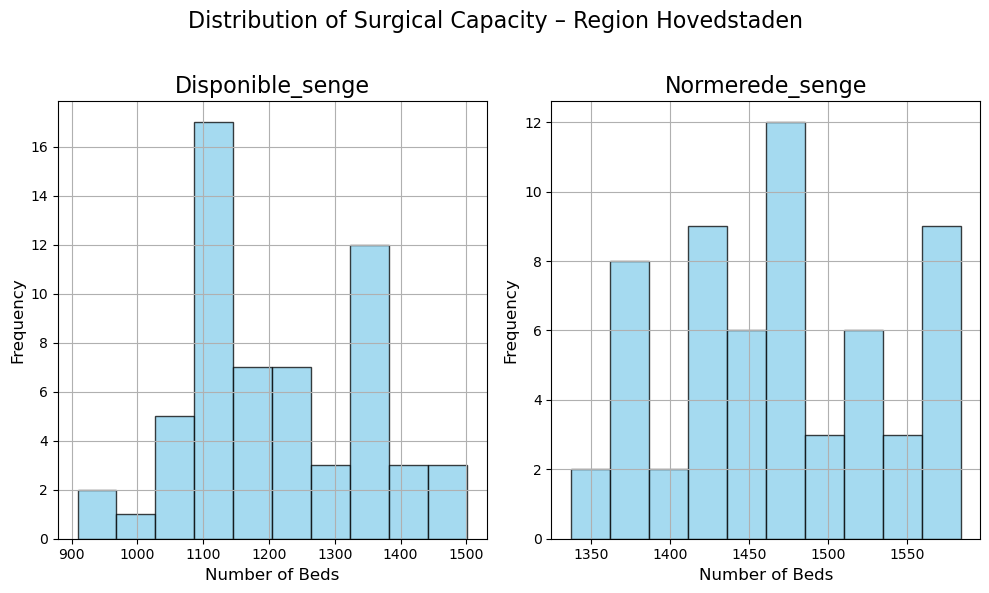

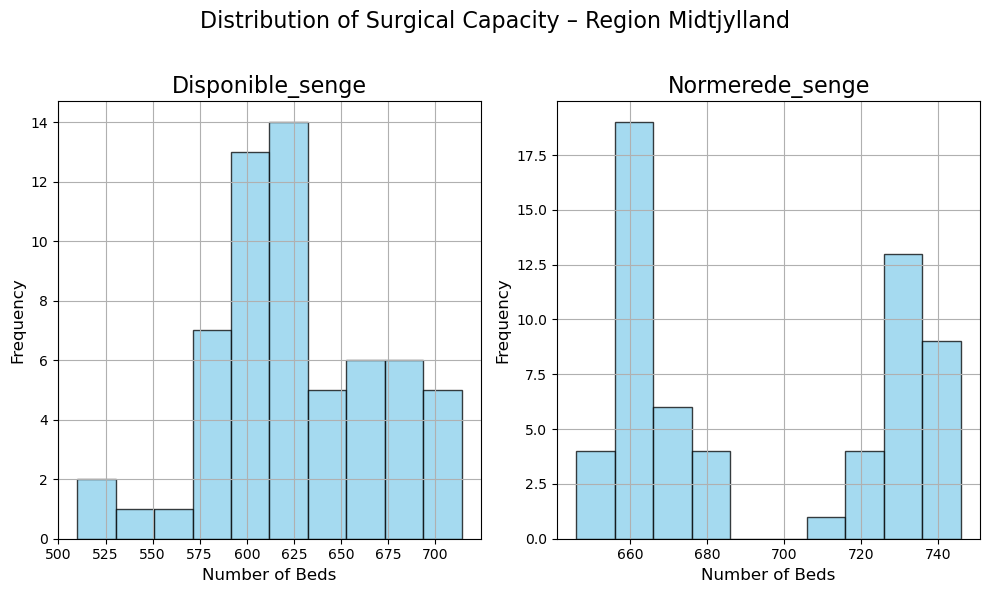

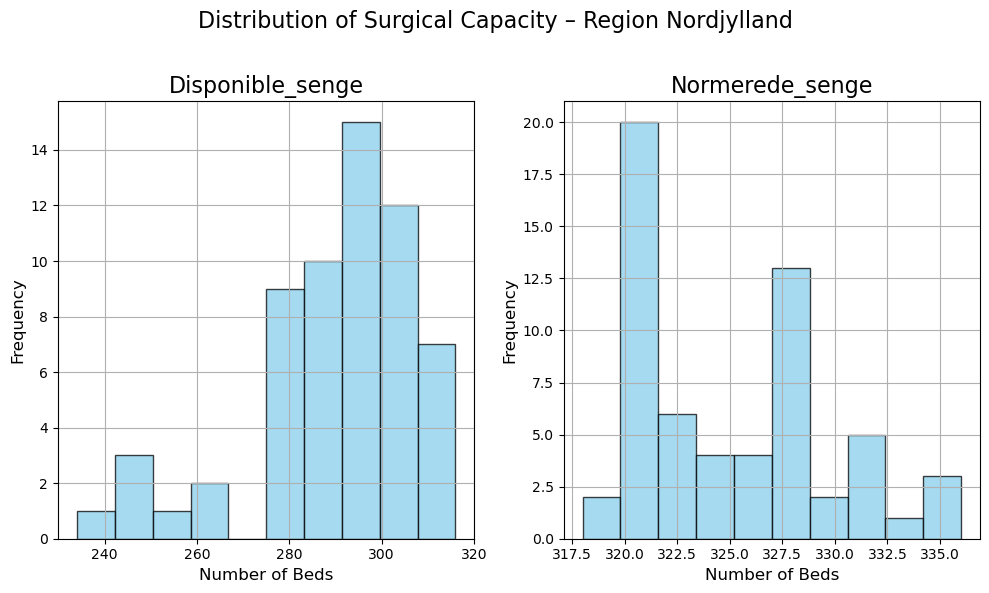

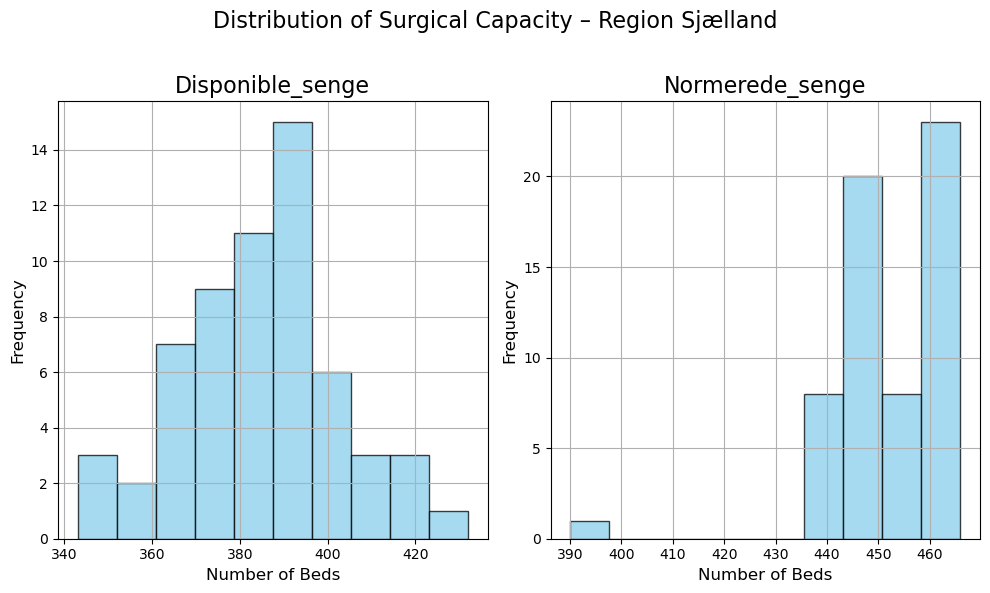

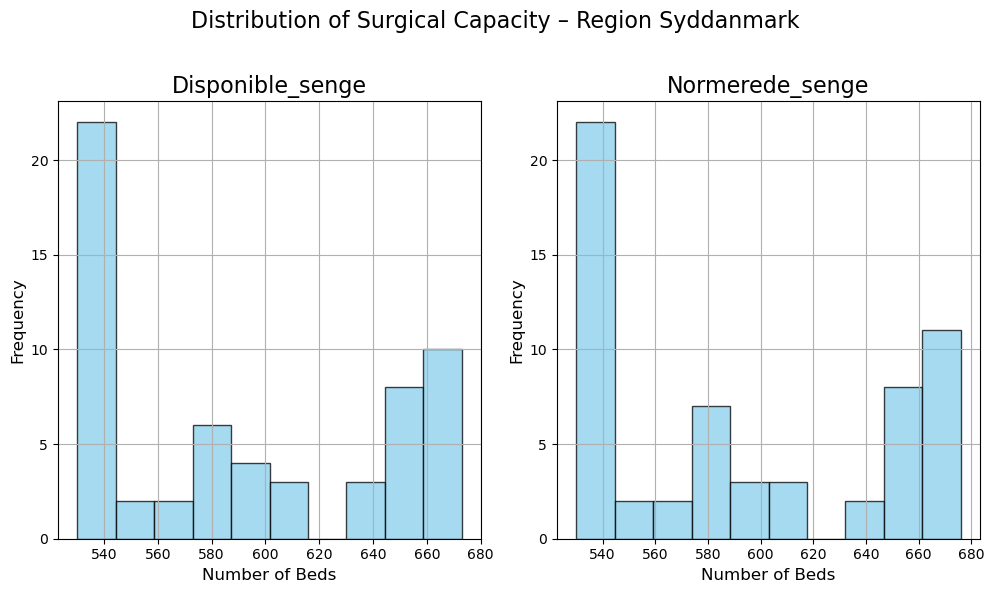

In [28]:
# These histograms show the distribution of available and normed surgical beds per region.
# Useful for seeing whether some regions consistently have higher or lower capacity.

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]
    plot_hosp_histogram(
        sub[["Disponible_senge", "Normerede_senge"]],
        title=f"Distribution of Surgical Capacity – {r}",
        x_label="Number of Beds",
        y_label="Frequency",
        color="skyblue",
    )

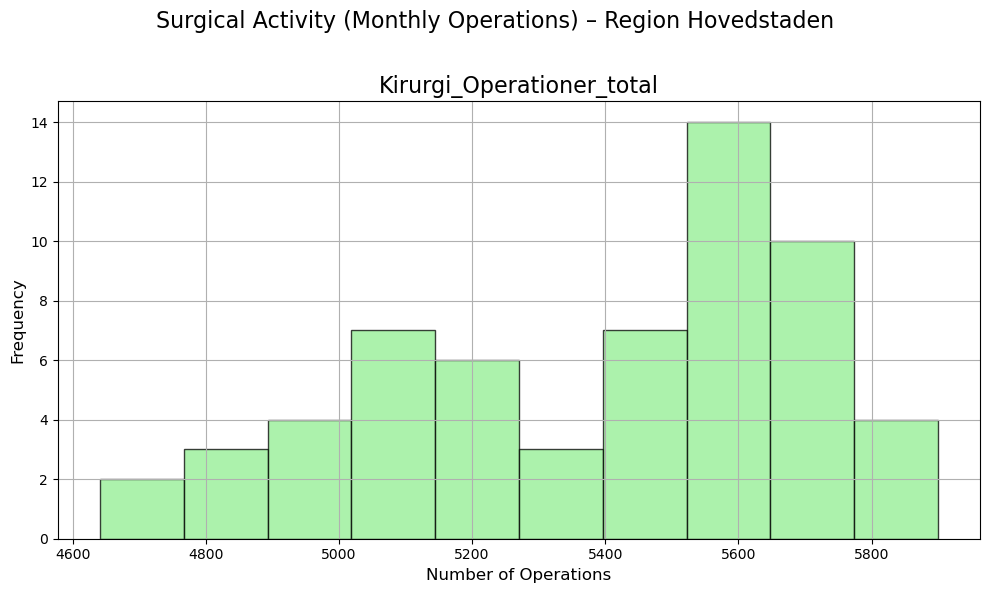

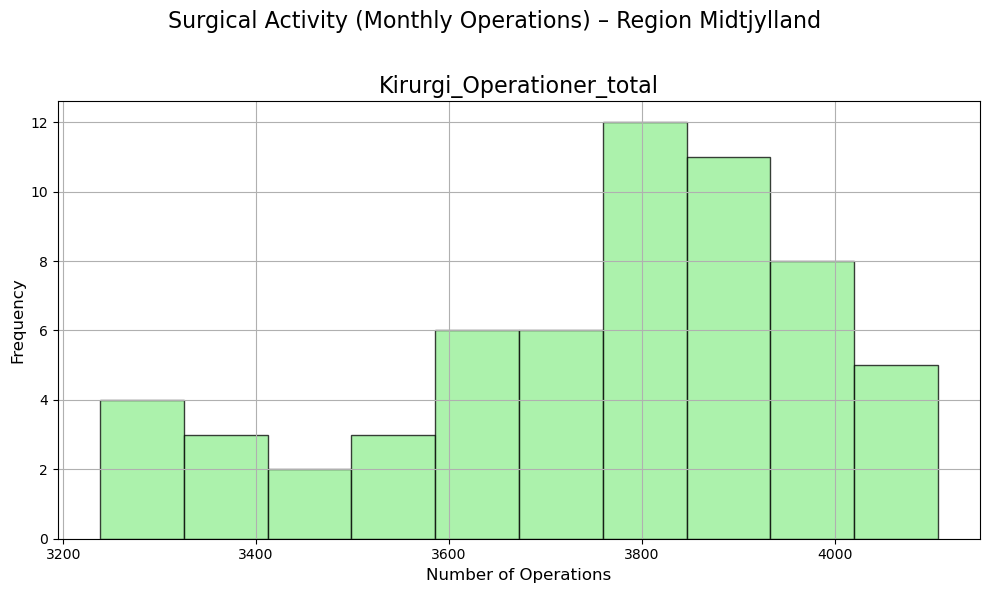

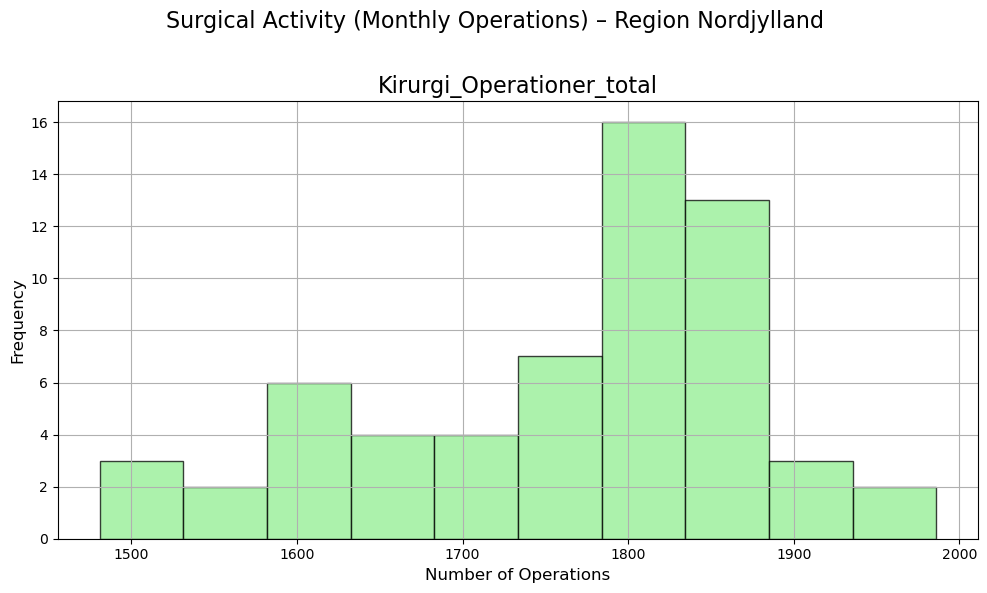

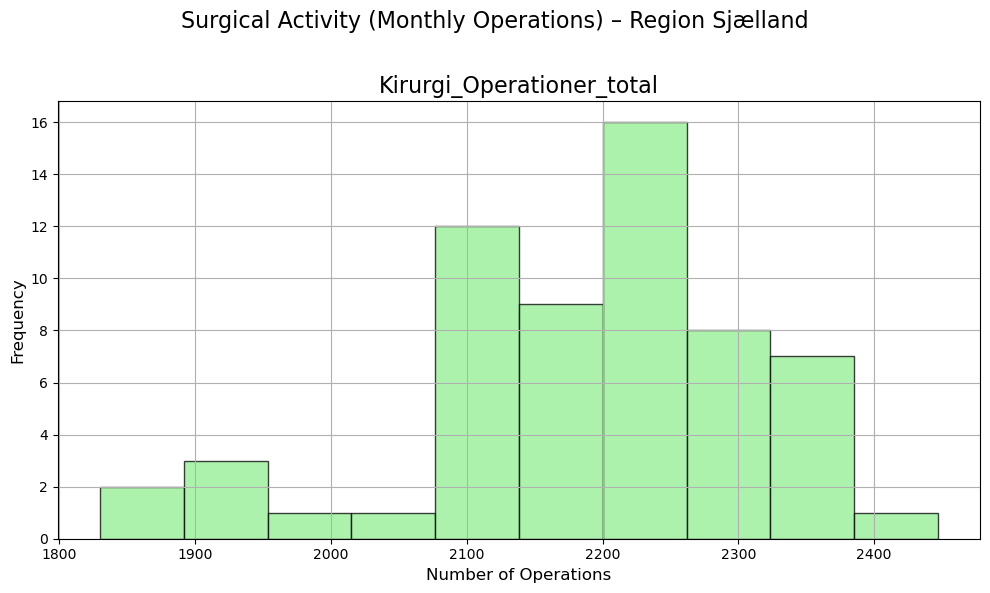

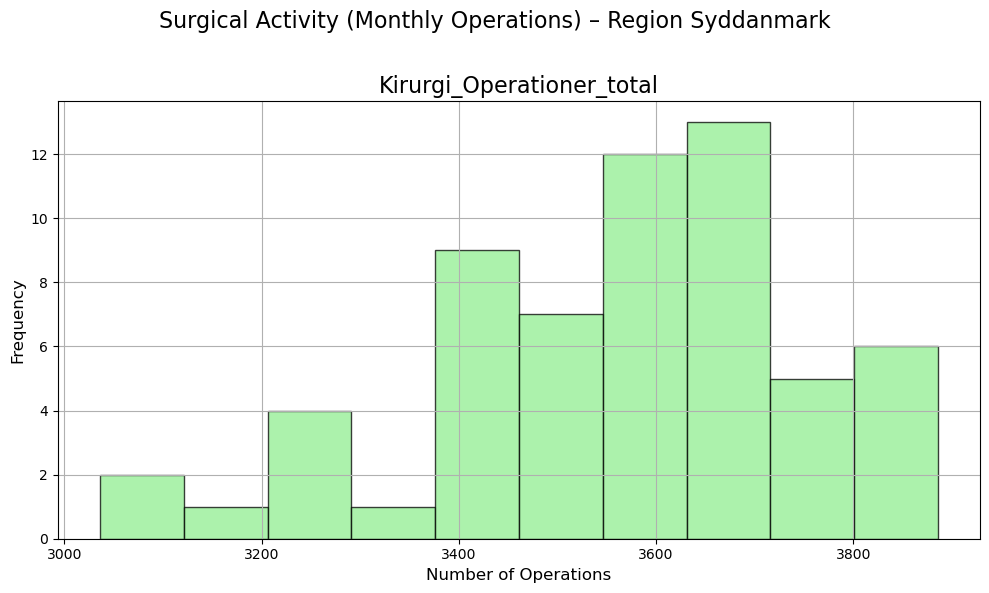

In [29]:
# Shows the distribution of total monthly surgical operations per region.
# Helps identify which regions have higher or lower activity levels or larger fluctuations.

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]
    plot_hosp_histogram(
        sub[["Kirurgi_Operationer_total"]],
        title=f"Surgical Activity (Monthly Operations) – {r}",
        x_label="Number of Operations",
        y_label="Frequency",
        color="lightgreen",
    )

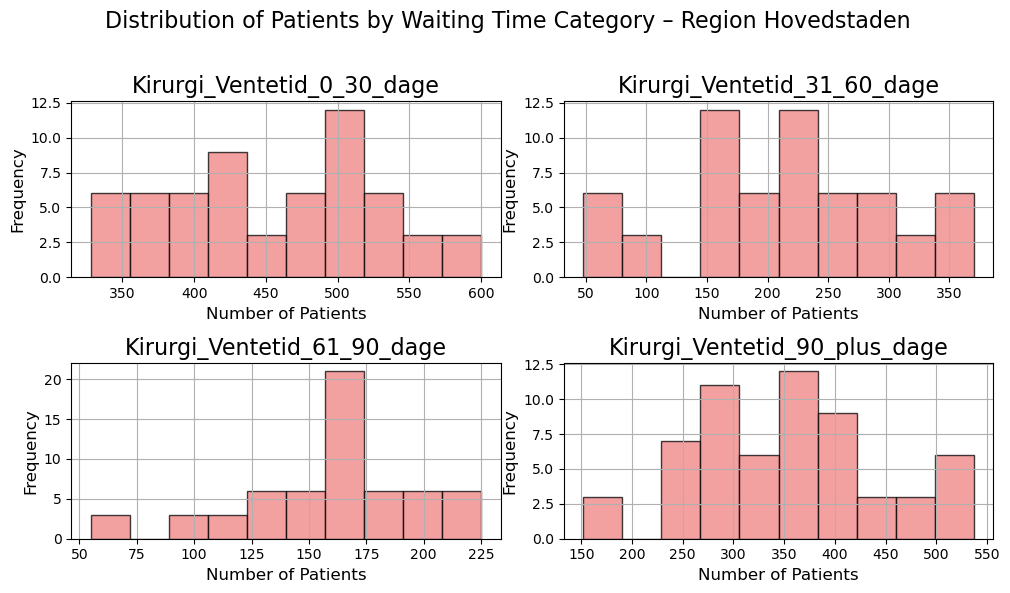

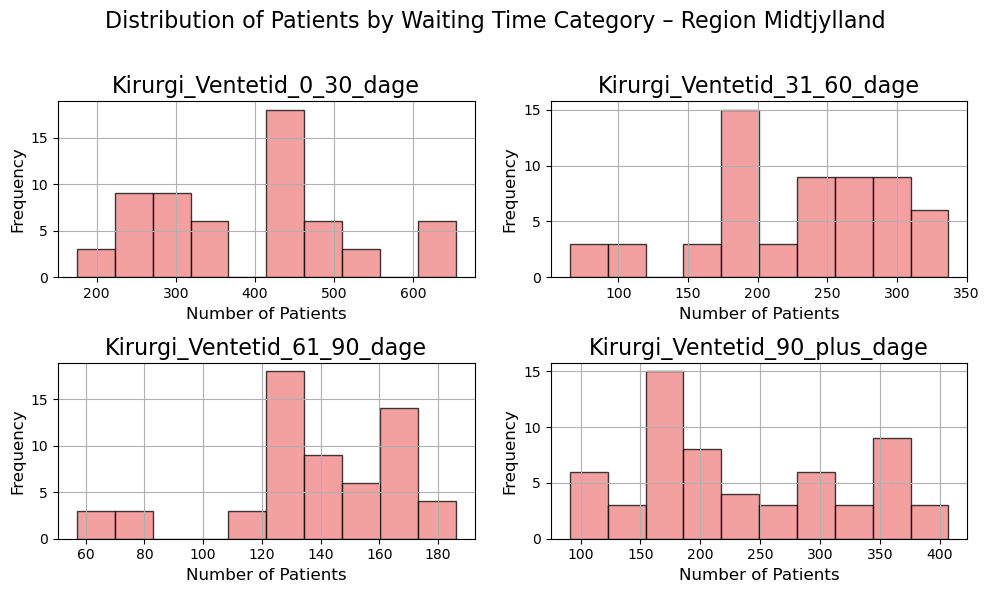

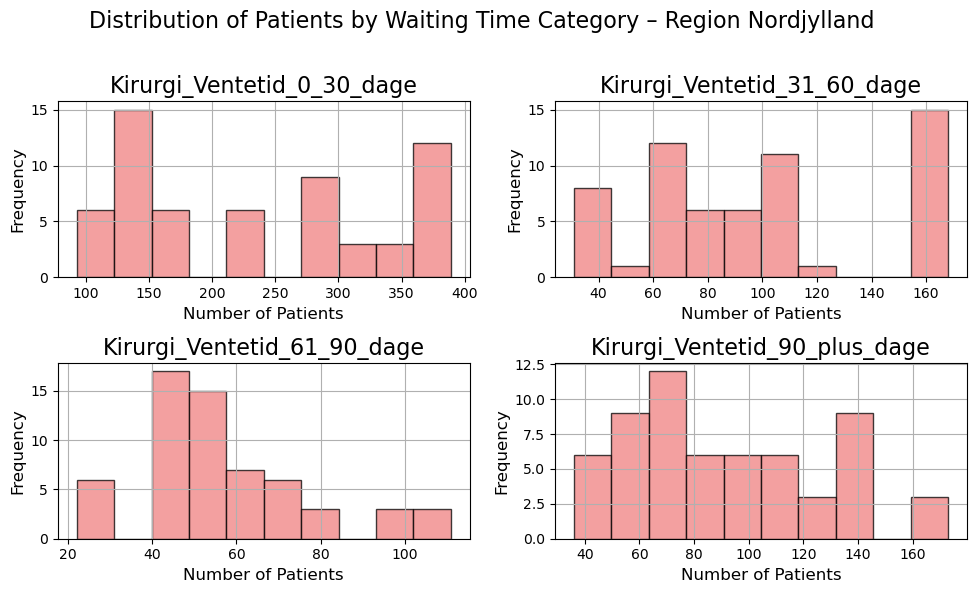

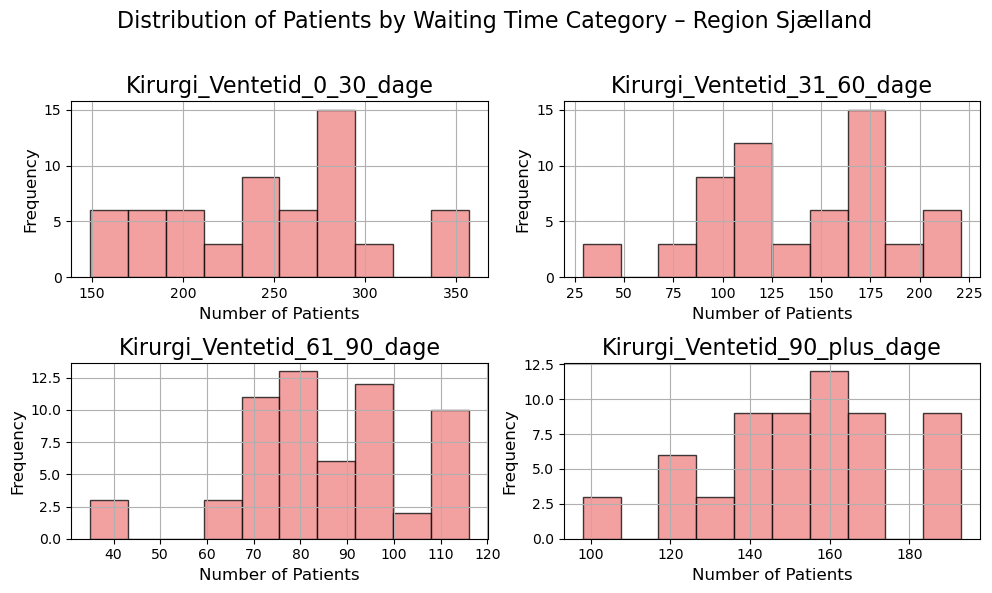

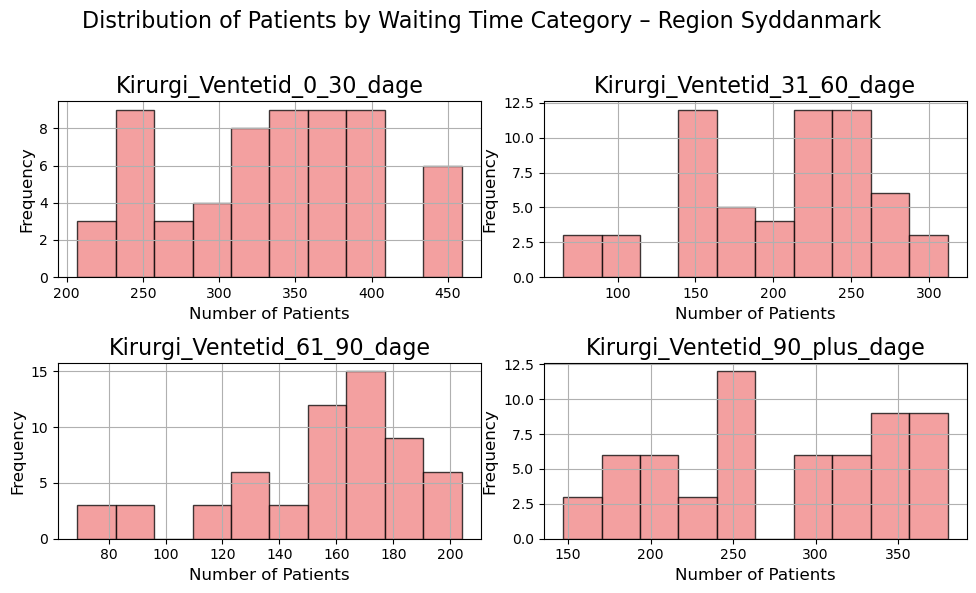

In [30]:
# Displays the number of patients within each waiting time category for each region.
# Helps compare whether some regions have more patients in the long waiting categories (e.g., 90+ days).

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]
    plot_hosp_histogram(
        sub[
            [
                "Kirurgi_Ventetid_0_30_dage",
                "Kirurgi_Ventetid_31_60_dage",
                "Kirurgi_Ventetid_61_90_dage",
                "Kirurgi_Ventetid_90_plus_dage",
            ]
        ],
        title=f"Distribution of Patients by Waiting Time Category – {r}",
        x_label="Number of Patients",
        y_label="Frequency",
        color="lightcoral",
    )

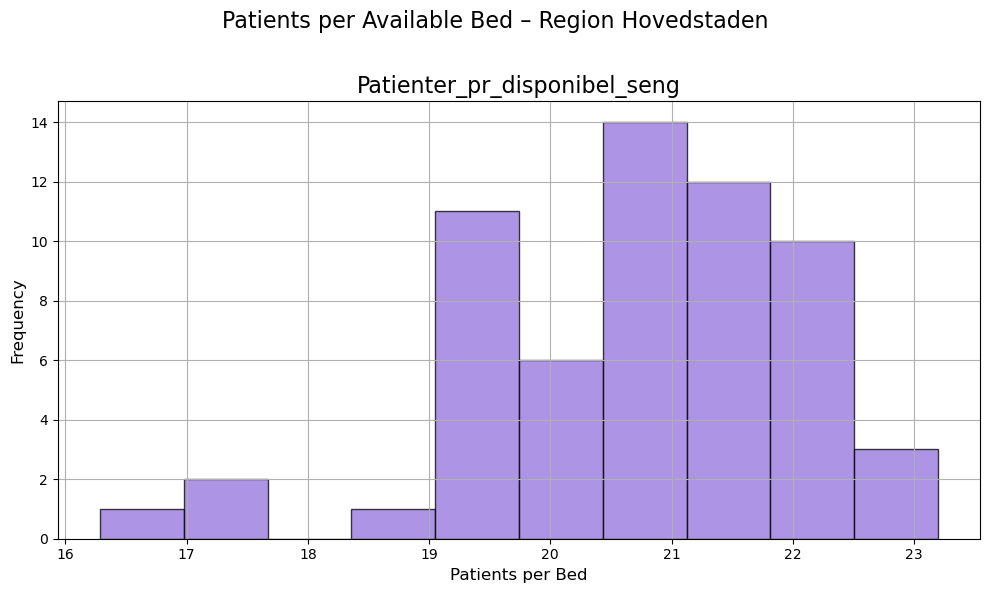

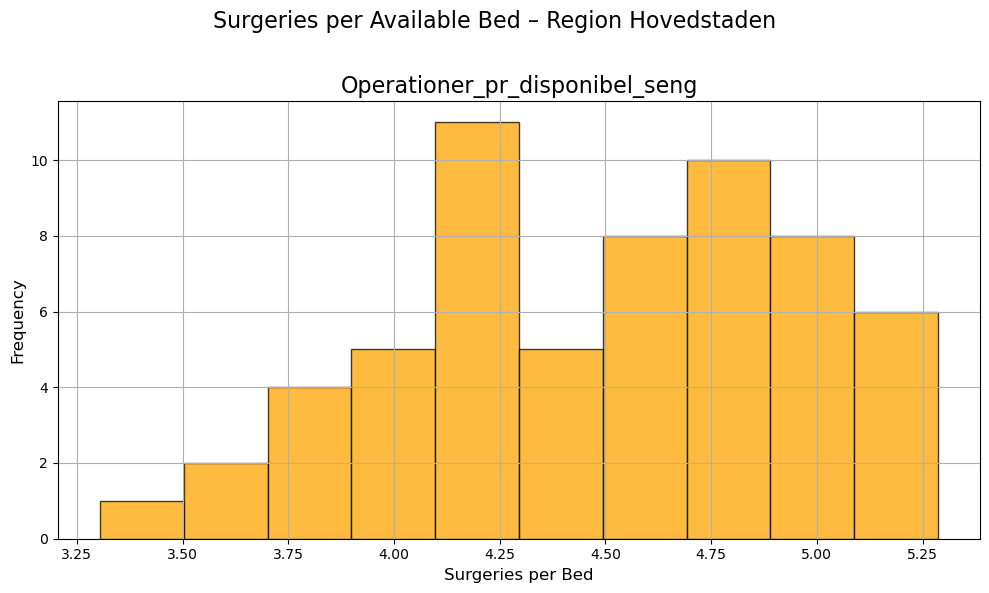

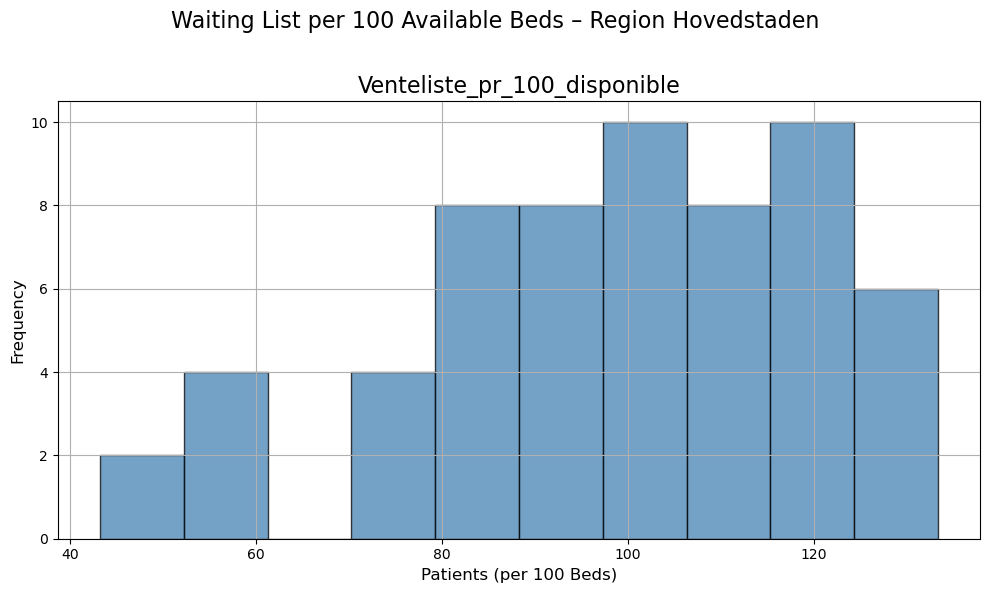

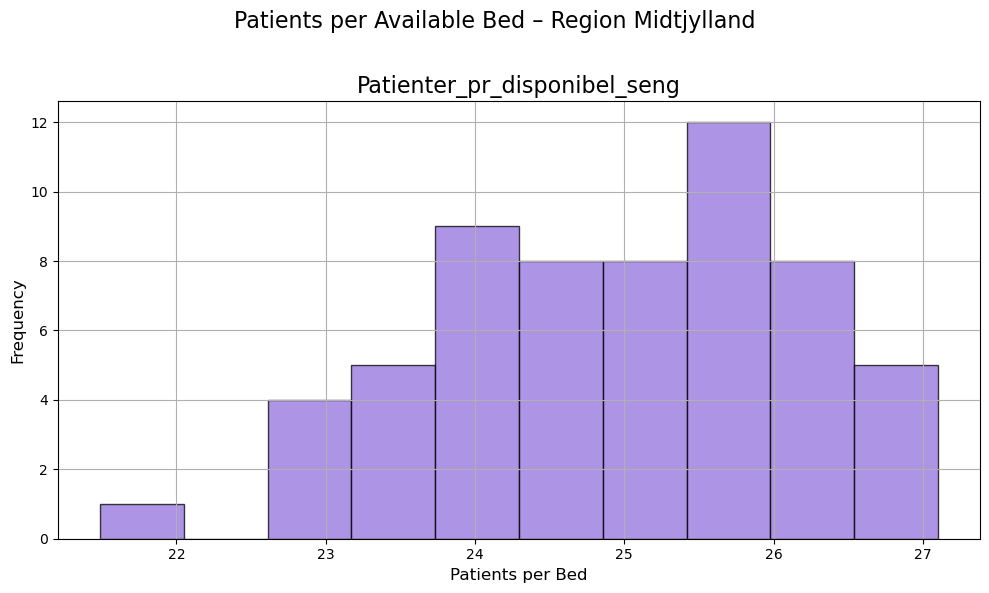

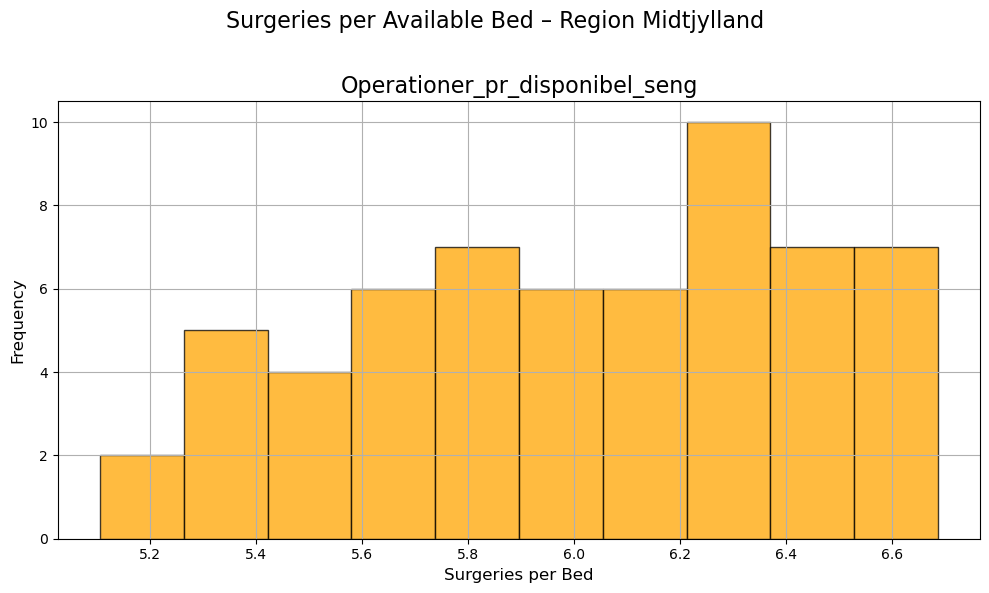

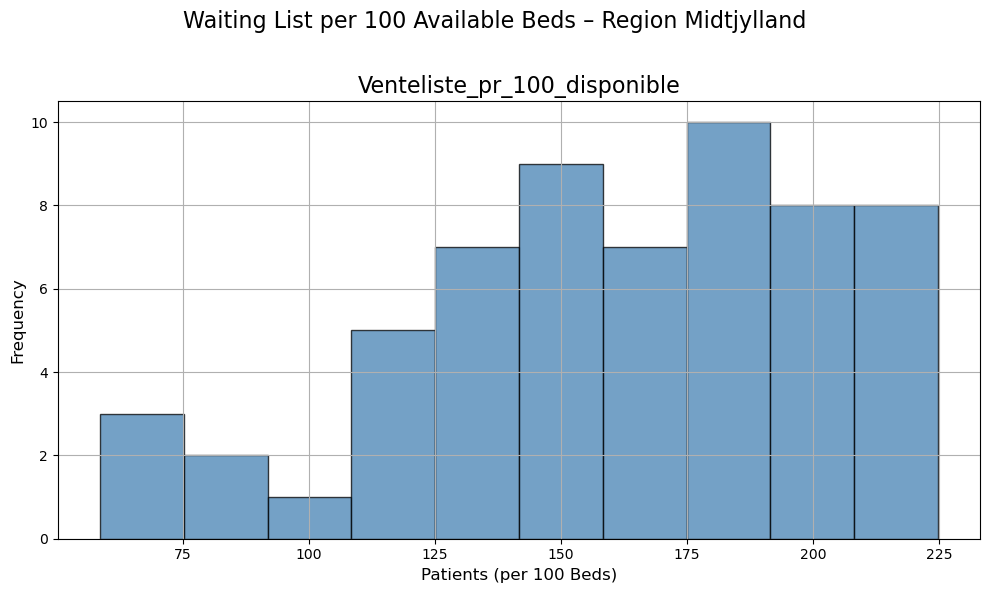

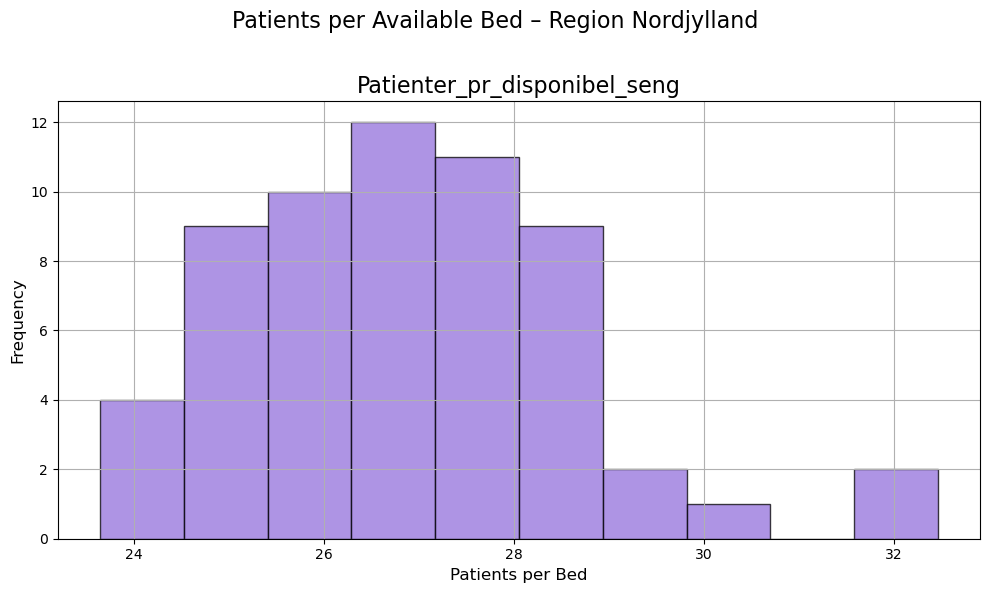

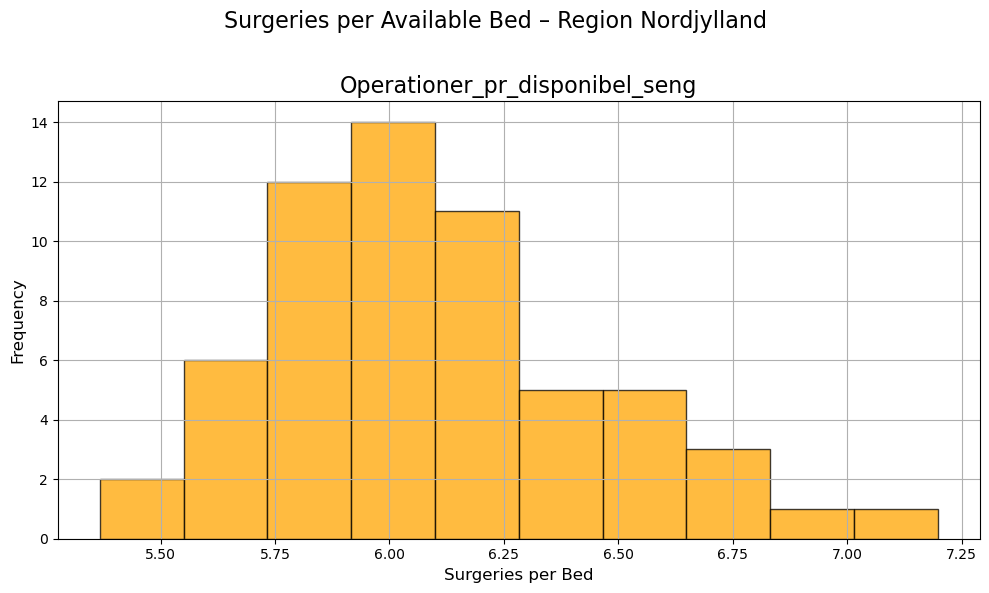

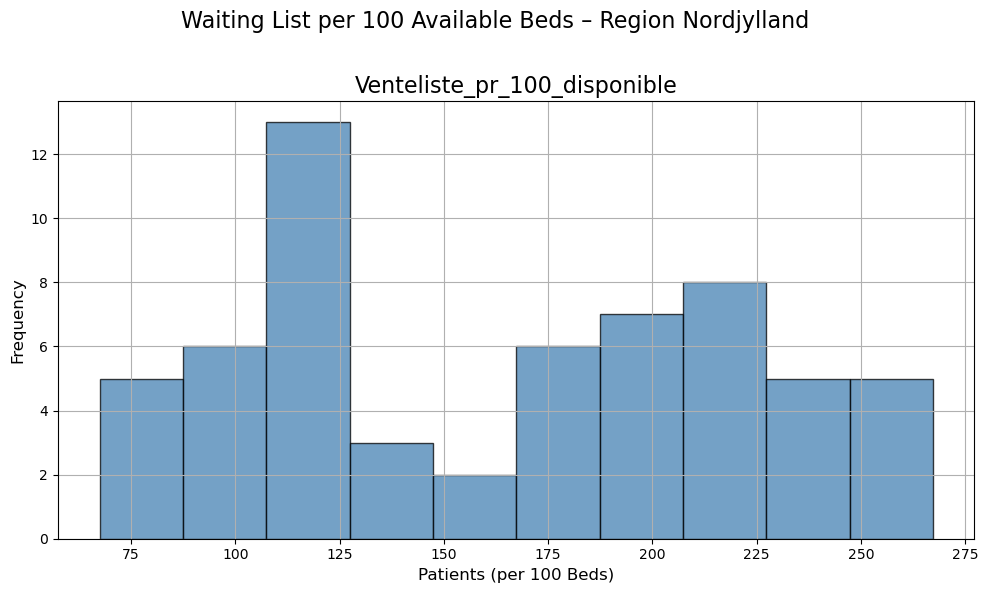

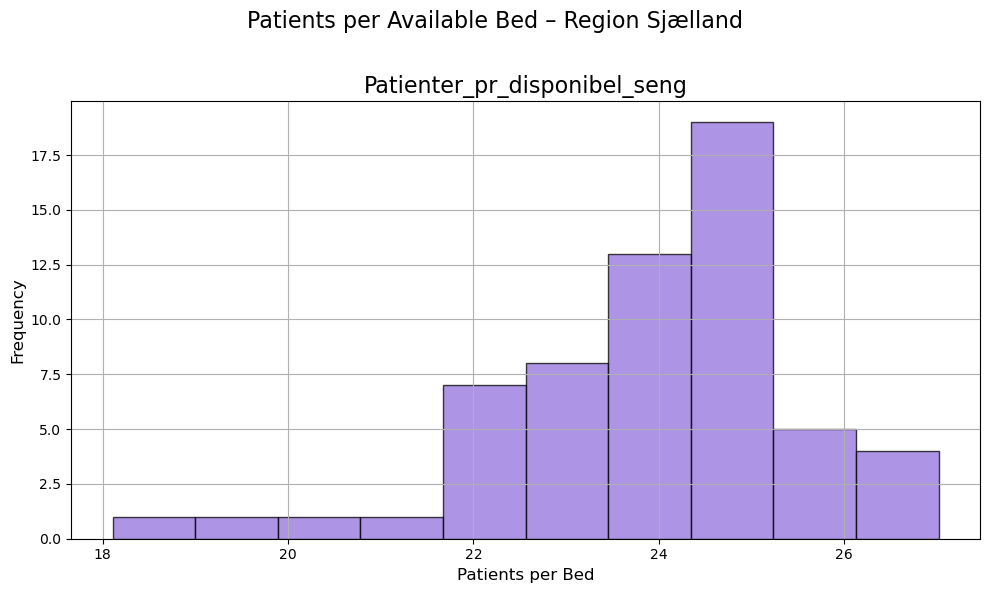

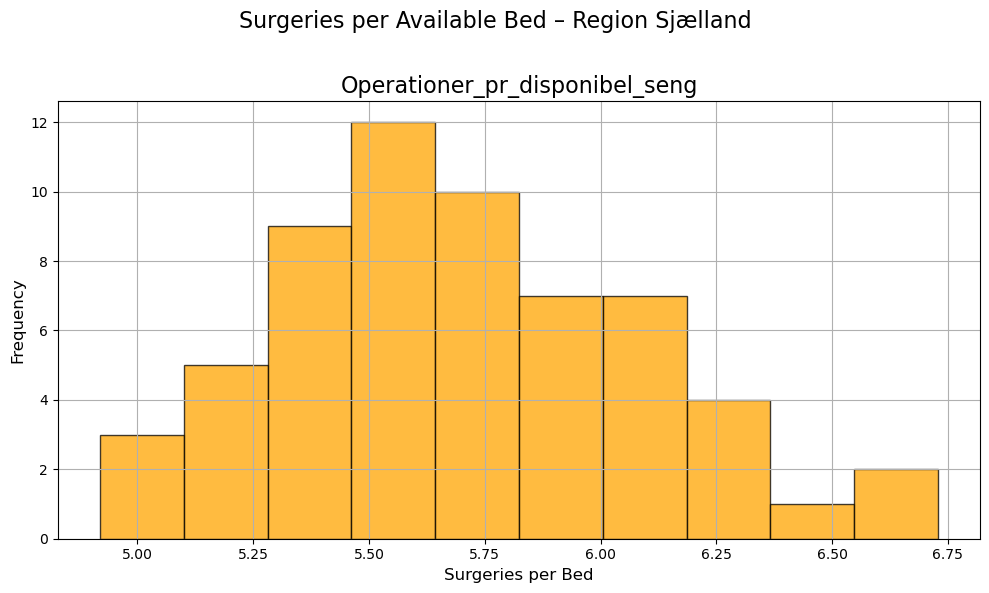

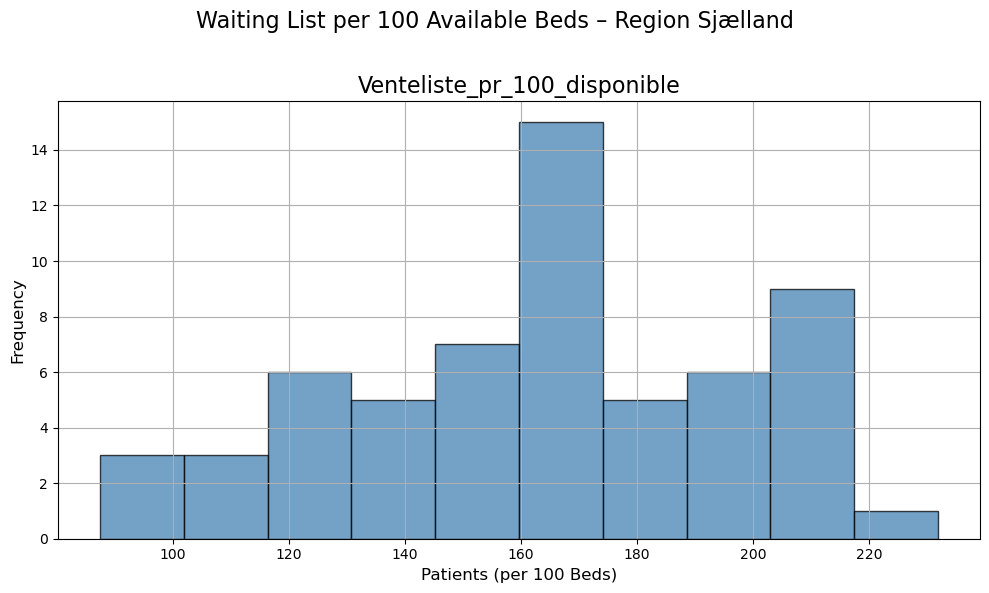

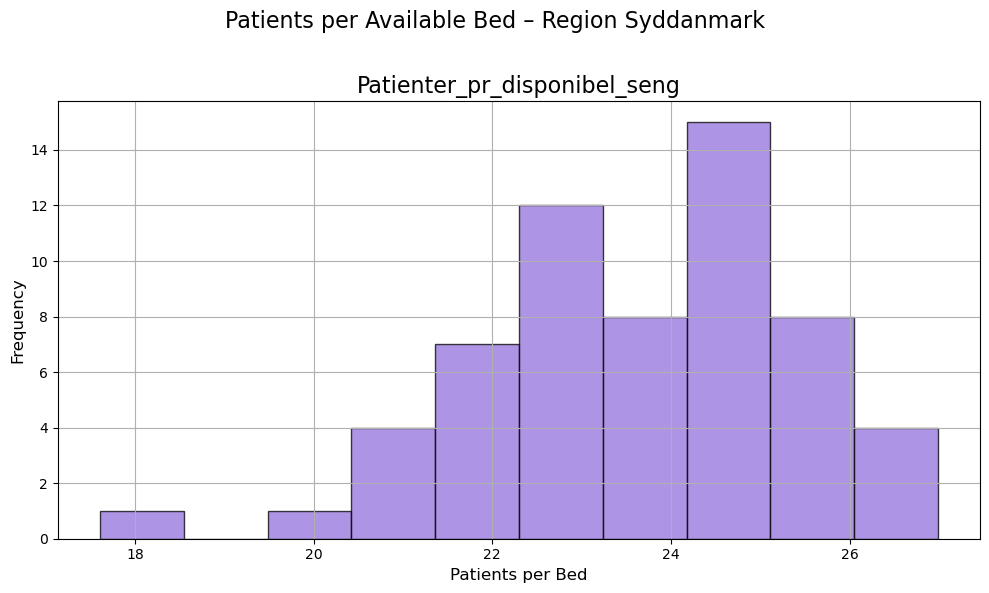

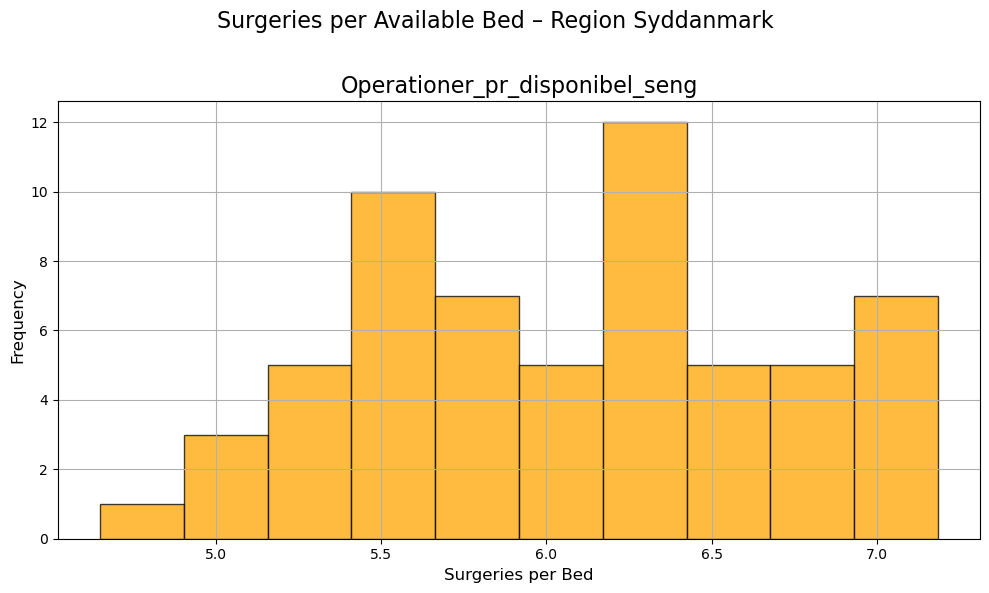

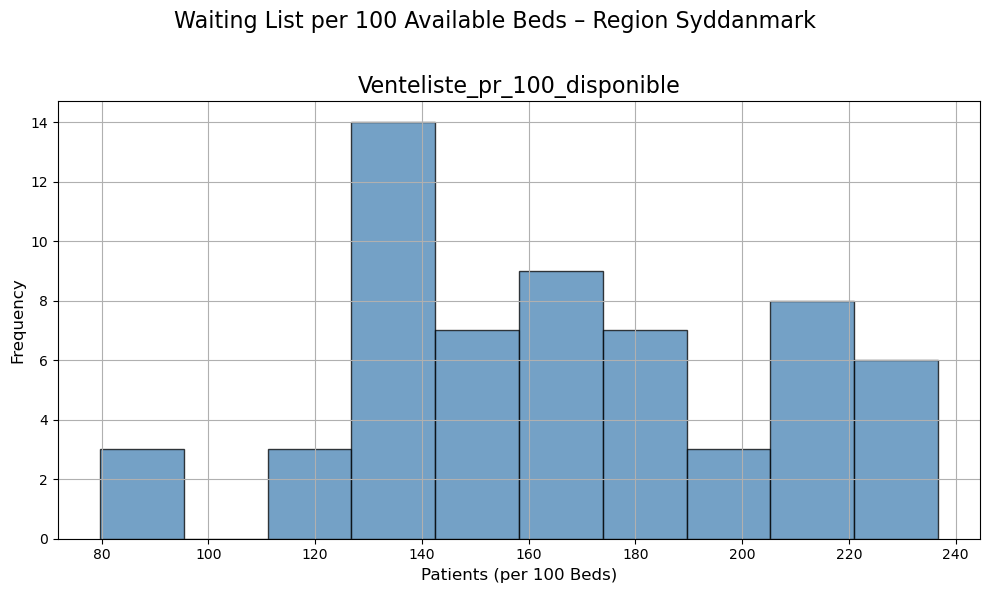

In [31]:
# These histograms visualize the derived KPIs, showing the relationship between activity, capacity, and waiting times.
# They reveal how efficiently each region utilizes its surgical capacity.

for r in regions:
    sub = all_kir_cleaned[all_kir_cleaned[REGION_COL] == r]

    # Patients per available bed: system load relative to capacity
    plot_hosp_histogram(
        sub[["Patienter_pr_disponibel_seng"]],
        title=f"Patients per Available Bed – {r}",
        x_label="Patients per Bed",
        y_label="Frequency",
        color="mediumpurple",
    )

    # Surgeries per available bed: how productive each region is with its capacity
    plot_hosp_histogram(
        sub[["Operationer_pr_disponibel_seng"]],
        title=f"Surgeries per Available Bed – {r}",
        x_label="Surgeries per Bed",
        y_label="Frequency",
        color="orange",
    )

    # Waiting list per 100 available beds: backlog intensity relative to capacity
    plot_hosp_histogram(
        sub[["Venteliste_pr_100_disponible"]],
        title=f"Waiting List per 100 Available Beds – {r}",
        x_label="Patients (per 100 Beds)",
        y_label="Frequency",
        color="steelblue",
    )

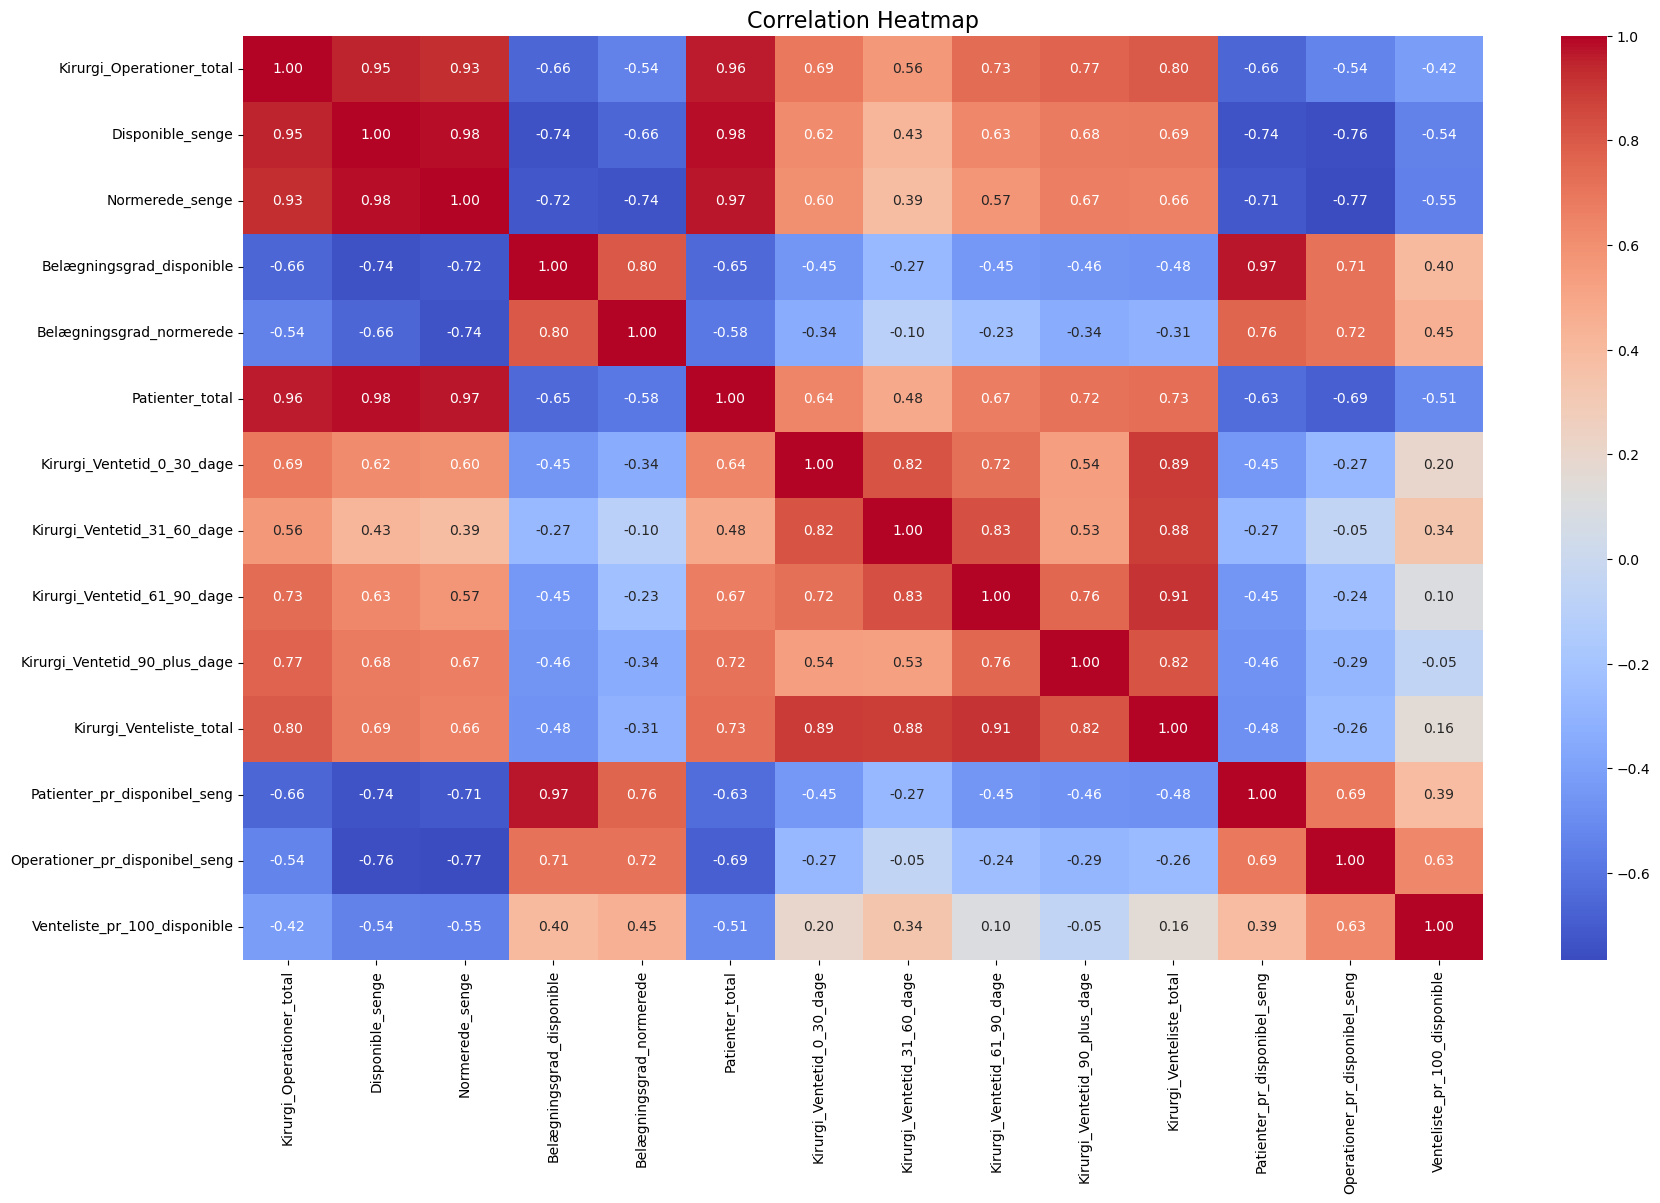

In [32]:
from hosp_heatmap import plot_hosp_heatmap

plot_hosp_heatmap(all_kir_cleaned)